In [18]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import math
import localizer_functions # custom stuff

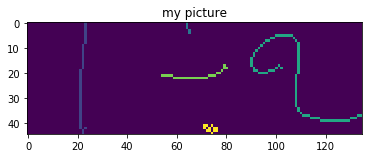

In [19]:
#src = cv2.imread('../images_no_copies/div/div_665.jpg')
src = cv2.imread('../generated_images/1div2/7.png')

gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
thresh = cv2.bitwise_not(thresh)
connectivity = 4  # You need to choose 4 or 8 for connectivity type
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh , connectivity , cv2.CV_32S, cv2.CCL_DEFAULT)

plt.imshow(labels)
plt.title("my picture")
plt.show()

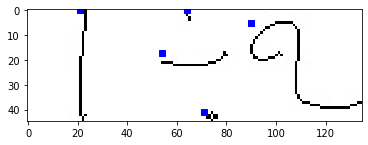

In [20]:
plt.imshow(src)
for i in range(1, num_labels):
    # get stats for i-th number by using stats[i, PROPERTY]
    left = stats[i, cv2.CC_STAT_LEFT]
    top = stats[i, cv2.CC_STAT_TOP]
    plt.plot(left, top, 'bs')
    #print(left, top)
plt.show()

overlaps is a list of tuples, with each tuple being (i, list) where the list is a list of digits which start within the x range of the i-th digit

In [21]:
# now trying to detect the overlaps
overlaps = [(i - 1,[]) for i in range(1, num_labels)] # zero based
for i in range(1, num_labels):
    left_i = stats[i, cv2.CC_STAT_LEFT]
    width_i = stats[i, cv2.CC_STAT_WIDTH]
    for j in range(1, num_labels):
        left_j = stats[j, cv2.CC_STAT_LEFT]
        # if left of j is within limits of i, add to the overlap list
        if left_j in range(left_i, left_i + width_i):
            _, l = overlaps[i - 1]
            l.append(j - 1)


print(overlaps)
# we only want to detect division, so we want a symbol with three overlaps
# the symbol itself (the line) and the two dots
division_symbols_pairs = list(filter(lambda x: len(x[1]) == 3, overlaps))
print(division_symbols_pairs)
digit_indices = np.arange(1, num_labels)
print(digit_indices)
# now filter all division symbols from our normal array, we will handle them later
for e in division_symbols_pairs:
    i, list_of_division_operator = e
    print(list_of_division_operator)
    digit_indices = np.delete(digit_indices, list_of_division_operator)
print(digit_indices)

[(0, [0]), (1, [1]), (2, [2]), (3, [1, 3, 4]), (4, [4])]
[(3, [1, 3, 4])]
[1 2 3 4 5]
[1, 3, 4]
[1 3]


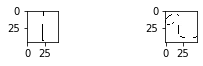

In [22]:
digits = []
for i in digit_indices:
    number = localizer_functions.extract_number(stats, src, i)
    squared = localizer_functions.make_square_out_of(number)
    digits.append(squared)
    num = plt.subplot(6,5,i)
    #cv2.imwrite(str(i) + "-sq.jpg", squared)
    num.imshow(squared)
plt.show()

In [23]:
[p] = division_symbols_pairs # zero based
division_symbols = []
for pair in division_symbols_pairs:
    image = localizer_functions.extract_square_division_symbol(p, stats, src)
    division_symbols.append(image)
#division_symbols

In [24]:
all_symbols = digits + division_symbols
#all_symbols.append(digits)
#all_symbols.append(division_symbols)
print(len(division_symbols))
print(len(all_symbols))
print(len(digits))
plt.show()

1
3
2


In [28]:
i = 1
for img in all_symbols:
    num = plt.subplot(6,5,i)
    i = i + 1
    
    cv2.imwrite(img, str(i) + ".png")
    num.imshow(img)
plt.show()

SystemError: <built-in function imwrite> returned NULL without setting an error